In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import collections
from os import listdir
%matplotlib inline
%run '/home/ihs3/Documents/Notebooks/rct008_import_getters.ipynb'

In [13]:
# These are the "Tableau 20" colors as RGB.    
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),    
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),    
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),    
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),    
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]    
  
# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.    
for i in range(len(tableau20)):    
    r, g, b = tableau20[i]    
    tableau20[i] = (r / 255., g / 255., b / 255.)    

Ein = Eout = $\dot{q}_{conv} + \dot{q}_{rad}$ <br>

where 

$\dot{q}_{conv} = hA\delta T$ <br>
$\dot{q}_{rad} = \epsilon \sigma A_h (T_h^4 - T_c^4)$


# HISTORICAL DATA
This data was collected from 2015-11 until 2016-04 <br>
The forms of heat transfer associated with this system is force convection. <br>
$E_{in} = E_{out} = \dot{q}_{conv}$

where 

$\dot{q}_{conv} = hA\delta T$ <br>
$\delta T = T_s - T_{\infty}$
$T_s = (RTD_{left} + RTD_{right}) / 2$

In [18]:
# Change filePath
# sorting Cal and Op data
filePath = '/home/ihs3/Documents/Notebooks/Data/rock/16kgOld/'
fileList = sorted([fn for fn in listdir(filePath) if (fn.startswith('Cal'))])
dfList = []
i = 0
for filename in fileList:
    dfList.append(i)
    i += 1
    
Cal1 = {}
for filename, name in zip(fileList, dfList):
    Cal1[name] = pd.read_csv(filePath+filename)
    Cal1[name] = Cal1[name].drop('Unnamed: 0', axis=1)

Cal = {}
for name in Cal1:
    newName = Cal1[name].ix[0, 'file']
    Cal[newName] = Cal1[name]
    
fileList = sorted([fn for fn in listdir(filePath) if (fn.startswith('Op'))])
dfList = []
i = 0
for filename in fileList:
    dfList.append(i)
    i += 1
    
Op1 = {}
for filename, name in zip(fileList, dfList):
    Op1[name] = pd.read_csv(filePath+filename)
    Op1[name] = Op1[name].drop('Unnamed: 0', axis=1)

Op = {}
for name in Op1:
    newName = Op1[name].ix[0, 'file']
    Op[newName] = Op1[name]

In [19]:
## Fix dictionary keys
for a in Cal.keys():
    if isinstance(a, np.int64):
        b = str(a)
        Cal[b] = Cal[a]
        del Cal[a]
for a in Op.keys():
    if isinstance(a, np.int64):
        b = str(a)
        Op[b] = Op[a]
        del Op[a]

In [20]:
# Select "steady state" time period
Cal['60212'] = Cal['60212'].ix[500:, :]
Cal['60225b'] = Cal['60225b'].ix[500:, :]
Cal['60225a'] = Cal['60225a'].ix[400:, :]
Cal['60226b'] = Cal['60226b'].ix[500:, :]
Cal['60224b'] = Cal['60224b'].ix[400:, :]
Cal['51210b'] = Cal['51210b'].ix[500:, :]
Cal['60224c'] = Cal['60224c'].ix[500:, :]
Cal['60206c'] = Cal['60206c'].ix[0:2000, :]
Cal['60130c'] = Cal['60130c'].ix[0:2250, :]
Cal['60205b'] = Cal['60205b'].ix[0:300, :]

Op['60306'] = Op['60306'].ix[500:, :]
Op['60307'] = Op['60307'].ix[0:3000, :]
Op['60304b'] = Op['60304b'].ix[500:, :]
Op['60318'] = Op['60318'].ix[1000:, :]
Op['60308'] = Op['60308'].ix[500:, :]

In [21]:
# Outlier - power input incorrectly
del Cal['51211a']

### Temperature Analysis <br>
Each temperature sensor is used to compare the temperature gradient along the reactor. <br>
$T_{delta} = T_{new} - T_{ambient}$

In [22]:
for fileName in Cal:
    Cal[fileName]['delta left'] = Cal[fileName]['new left'] - Cal[fileName]['ambient']
    Cal[fileName]['delta right'] = Cal[fileName]['new right'] - Cal[fileName]['ambient']
    Cal[fileName]['delta center'] = Cal[fileName]['new core'] - Cal[fileName]['ambient']

for fileName in Op:
    Op[fileName]['delta left'] = Op[fileName]['new left'] - Op[fileName]['ambient']
    Op[fileName]['delta right'] = Op[fileName]['new right'] - Op[fileName]['ambient']
    Op[fileName]['delta center'] = Op[fileName]['new core'] - Op[fileName]['ambient']

/home/ihs3/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/home/ihs3/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/home/ihs3/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in

In [23]:
pMeanList = []
fileList  = []
deltaR = []
deltaC = []
deltaL = []

for number in Cal:
    pMeanList.append(Cal[number]['input power w/ac'].mean())
    deltaL.append((Cal[number]['new left'] - Cal[number]['ambient']).mean())
    deltaC.append((Cal[number]['new core'] - Cal[number]['ambient']).mean())
    deltaR.append((Cal[number]['new right'] - Cal[number]['ambient']).mean())

    fileList.append(number)
    
calStatsDf = pd.DataFrame([fileList, pMeanList, deltaR, deltaC, deltaL])
calStatsDf = calStatsDf.T
calStatsDf.columns = ['File', 'Power Mean', 'Delta R', 'Delta C', 'Delta L']
calStatsDf = calStatsDf.sort_values(by='File', ascending=1)
calStatsDf.reset_index(inplace = True)
calStatsDf = calStatsDf.drop('index', axis = 1)


pMeanList = []
fileList  = []
deltaR = []
deltaC = []
deltaL = []

for number in Op:
    pMeanList.append(Op[number]['input power w/ac'].mean())
    deltaL.append((Op[number]['new left'] - Op[number]['ambient']).mean())
    deltaC.append((Op[number]['new core'] - Op[number]['ambient']).mean())
    deltaR.append((Op[number]['new right'] - Op[number]['ambient']).mean())
    
    fileList.append(number)

opStatsDf = pd.DataFrame([fileList, pMeanList, deltaR, deltaC, deltaL])
opStatsDf = opStatsDf.T
opStatsDf.columns = ['File', 'Power Mean', 'Delta R', 'Delta C', 'Delta L']
opStatsDf = opStatsDf.sort_values(by='File', ascending=1)
opStatsDf.reset_index(inplace = True)
opStatsDf = opStatsDf.drop('index', axis = 1)

# 16kg system DATA
This data was collected from 2016-08-03 until 2016-08-11. <br>
There are three groups of data; Calibration (200Pa of He), Vacuum, and Operation (200Pa of D2) <br>


In [24]:
#ALL EVENTS: 200Pa of D, 200Pa of He
path = '/home/ihs3/Documents/Notebooks/Data/rock/16kg/'
lEventId =[[1,path+'ROCK_2016-08-03.csv', '2016-08-03 14:30:00', '2016-08-03 16:50:00']] #D 30C
lEventId.append([1,path+'ROCK_2016-08-04.csv', '2016-08-04 00:00:00', '2016-08-04 08:20:00']) #D 92C
lEventId.append([1,path+'ROCK_2016-08-04.csv', '2016-08-04 12:00:00', '2016-08-04 15:40:00']) #D 152C
lEventId.append([1,path+'ROCK_2016-08-05.csv', '2016-08-05 00:00:00', '2016-08-05 08:40:00']) #D 197C
lEventId.append([1,path+'ROCK_2016-08-05.csv', '2016-08-05 11:40:00', '2016-08-05 15:40:00']) #D 242C
lEventId.append([1,path+'ROCK_2016-08-06.csv', '2016-08-06 00:00:00', '2016-08-06 08:10:00']) #D 287C
lEventId.append([1,path+'ROCK_2016-08-06.csv', '2016-08-06 11:00:00', '2016-08-06 15:10:00']) #D 328C
lEventId.append([1,path+'ROCK_2016-08-06.csv', '2016-08-06 23:20:00', '2016-08-06 23:59:55']) #D 30C
lEventId.append([2,path+'ROCK_2016-08-07.csv', '2016-08-07 00:00:00', '2016-08-07 10:00:00']) #Vac 30C
lEventId.append([2,path+'ROCK_2016-08-07.csv', '2016-08-07 14:00:00', '2016-08-07 23:59:55']) #Vac 30C
lEventId.append([3,path+'ROCK_2016-08-08.csv', '2016-08-08 00:00:00', '2016-08-08 10:00:00']) #He 30C
lEventId.append([3,path+'ROCK_2016-08-09.csv', '2016-08-09 00:00:00', '2016-08-09 08:20:00']) #He 92C
lEventId.append([3,path+'ROCK_2016-08-09.csv', '2016-08-09 12:00:00', '2016-08-09 15:40:00']) #He 144C
lEventId.append([3,path+'ROCK_2016-08-10.csv', '2016-08-10 00:00:00', '2016-08-10 08:20:00']) #He 195C
lEventId.append([3,path+'ROCK_2016-08-10.csv', '2016-08-10 12:00:00', '2016-08-10 15:30:00']) #He 239C
lEventId.append([3,path+'ROCK_2016-08-11.csv', '2016-08-11 00:00:00', '2016-08-11 08:30:00']) #He 285C
lEventId.append([3,path+'ROCK_2016-08-11.csv', '2016-08-11 12:00:00', '2016-08-11 14:00:00']) #He 338C

In [25]:
#Creating Dataframe to split gas types
df = pd.DataFrame(lEventId)
df.columns = ['Event', 'filename', 'start', 'end']

df1 = df[df['Event'] == 1]
df2 = df[df['Event'] == 2]
df3 = df[df['Event'] == 3]

In [26]:
def calculations(filename,start,end):
    
    ''' NAME
        calculations - calculates Power in, Power out, and temperature difference between RTD and ambient. 

    FILE
        ROCKCSVDataAnalysis.ipynb

    DESCRIPTION
        filename: string name of CSV file
        start:    string start time of steady state
        end:      string end time of steady state

        The list named lEventId contains the event number, filename, start, and end times. All these values are
        entered in by hand. 
        This calculation sums the individual RTD data over time before taking the mean. Then the value is added
        with other RTDs and divided by the number of RTDs. The same is done for TC (Ambient temperature).

    EXAMPLES
        [pIn, pOut, Temp] = calculations('ROCK_2016-08-03.csv', '2016-08-03 14:30:00', '2016-08-03 16:50:00')
        [pIn, pOut, Temp] = calculations(lEventId[0][1],lEventId[0][2],lEventId[0][3])'''
    
    df = pd.read_csv(filename)
    df.set_index(pd.to_datetime(df[' Date']), inplace=True)

    # convert to eng units
    # Slot3V1: Blower current sense voltage.  divide by 3 to get current in amps
    # Slot3V2: Pressure voltage.  muliply by 1330 to get pressure in pascals
    # Slot3V5: Heater voltage monitor.  multiply by 24 to get voltage in volts
    # Slot3V6: Heater current monitor.  Multiply by 2.5 to get current in amps

    df['fanV-Mean'] = df['  Slot2V1-Mean'] / 1.
    df['fanV-Min'] = df['  Slot2V1-Min'] / 1.
    df['fanV-Max'] = df['  Slot2V1-Max'] / 1.
    df['fanV-Med'] = df['  Slot2V1-Med'] / 1.
    df['fanV-RMS'] = df[' Slot2V1-RMS'] / 1.

    df['fanA-Mean'] = df[' Slot3V1-Mean'] / 3.
    df['fanA-Min'] = df[' Slot3V1-Min'] / 3.
    df['fanA-Max'] = df[' Slot3V1-Max'] / 3.
    df['fanA-Med'] = df[' Slot3V1-Med'] / 3.
    df['fanA-RMS'] = df[' Slot3V1-RMS'] / 3.

    df['pressure-Mean'] = df[' Slot3V2-Mean'] * 1330.
    df['pressure-Min'] = df[' Slot3V2-Min'] * 1330.
    df['pressure-Max'] = df[' Slot3V2-Max'] * 1330.
    df['pressure-Med'] = df[' Slot3V2-Med'] * 1330.
    df['pressure-RMS'] = df[' Slot3V2-RMS'] * 1330.

    df['heaterV-Mean'] = df['  Slot3V5-Mean'] * 24.
    df['heaterV-Min'] = df[' Slot3V5-Min'] * 24.
    df['heaterV-Max'] = df[' Slot3V5-Max'] * 24.
    df['heaterV-Med'] = df[' Slot3V5-Med'] * 24.
    df['heaterV-RMS'] = df[' Slot3V5-RMS'] * 24.

    df['heaterA-Mean'] = df[' Slot3V6-Mean'] * 2.5
    df['heaterA-Min'] = df[' Slot3V6-Min'] * 2.5
    df['heaterA-Max'] = df[' Slot3V6-Max'] * 2.5
    df['heaterA-Med'] = df[' Slot3V6-Med'] * 2.5
    df['heaterA-RMS'] = df[' Slot3V6-RMS'] * 2.5

    df['heaterPower-Mean'] = df['heaterA-Mean'] * df['heaterV-Mean']
    df['fanPower-Mean'] = df['fanA-Mean'] * df['fanV-Mean']

    # get all the means
    meanCol = [col for col in df.columns if 'Mean' in col]
    dfMean = df[meanCol]

    # CALCULATIONS 
    #1) POWER IN = heater power t+ fan power
    powerIn = np.mean((dfMean.loc[start:end,'heaterPower-Mean']) + (dfMean.loc[start:end,'fanPower-Mean']))
    
    #2) TEMPERATURES = RTDs - Ambient
    Amb = dfMean.loc[start:end,' RTD7-Mean']
    RTDs = (dfMean.loc[start:end,' RTD1-Mean']+dfMean.loc[start:end,' RTD2-Mean']+
            dfMean.loc[start:end,' RTD5-Mean']+dfMean.loc[start:end,' RTD6-Mean'])*0.25
    CenterRTD = (dfMean.loc[start:end,' RTD3-Mean']+dfMean.loc[start:end,' RTD4-Mean'])*0.5
    
    Temps = np.mean(RTDs - Amb)
    CenterTemps = np.mean(CenterRTD - Amb)
    return powerIn, Temps, CenterTemps

In [27]:
operationPowerInData = []
operationTemperatures = []
operationCenterTemps = []

for x in range (0,len(df1)):
    [A,B,C]=calculations(df1.iloc[x,1],df1.iloc[x,2],df1.iloc[x,3])
    operationPowerInData.append(A)
    operationTemperatures.append(B)
    operationCenterTemps.append(C)
    
vacuumPowerInData = []
vacuumTemperatures = []
vacuumCenterTemps = []

for x in range (0,len(df2)):
    [A,B,C]=calculations(df2.iloc[x,1],df2.iloc[x,2],df2.iloc[x,3])
    vacuumPowerInData.append(A)
    vacuumTemperatures.append(B)
    vacuumCenterTemps.append(C)

calibrationPowerInData = []
calibrationTemperatures = []
calibrationCenterTemps = []

for x in range (0,len(df3)):
    [A,B,C]=calculations(df3.iloc[x,1],df3.iloc[x,2],df3.iloc[x,3])
    calibrationPowerInData.append(A)
    calibrationTemperatures.append(B)
    calibrationCenterTemps.append(C)

# 50kg DATA
This was run from 2016-08-23 until 2016-08-26 <br>
Ambient RTDs are 9 and 10 <br>
Reactor RTDs are 1, 2, 3, 4, 5, 6. RTDs 3 and 4 and under insulation and will not be used for calculation. <br>

The heat transfer associated with this system is force convection and radiation <br>
Ein = Eout = $\dot{q}_{conv} + \dot{q}_{rad}$

In [28]:
# links to where the data files are stored
filePath = '/home/ihs3/Documents/Notebooks/Data/rock/50kg/'
fileList = sorted([fn for fn in listdir(filePath) if (fn.startswith('rock50kg'))])

In [29]:
def calcPowerVal(df):
    # right now take the mean of all the RTD 
    # mean over time and sensors (order does not matter)
    tAmbMean = (np.mean(df['RTD9-Mean'])+np.mean(df['RTD10-Mean']))*0.5

    # flow in is essentially ambient, take the mean 
    # mean over time and sensors (order does not matter)
    tRctMean = (df['RTD1-Mean']+df['RTD2-Mean']+
                        df['RTD5-Mean']+df['RTD6-Mean'])*0.25
    tRct15Mean = (df['RTD1-Mean']+df['RTD5-Mean'])*0.5
    tRct26Mean = (df['RTD2-Mean']+df['RTD6-Mean'])*0.5
    tRct12Mean = (df['RTD1-Mean']+df['RTD2-Mean'])*0.5
    tRct56Mean = (df['RTD5-Mean']+df['RTD6-Mean'])*0.5
    
    Temp50 = np.mean(tRctMean - tAmbMean)
    Temp15 = np.mean(tRct15Mean - tAmbMean)
    Temp26 = np.mean(tRct26Mean - tAmbMean)
    Temp12 = np.mean(tRct12Mean - tAmbMean)
    Temp56 = np.mean(tRct56Mean - tAmbMean)
    
    # heater power + fan power
    wPowIn = df['heaterPower-Mean'].mean() + df['fanPower-Mean'].mean()

    return Temp50, wPowIn, Temp15, Temp26, tRctMean, tAmbMean, Temp12, Temp56

In [30]:
Temp50 = []
Temp15 = []
Temp26 = []
pIn50 = []
tRctMean = []
tAmbMean = []
Temp12 = []
Temp56 = []

for filename in fileList:
    #print filename
    df = pd.read_pickle(filePath+filename)
    temp = calcPowerVal(df)
    Temp50.append(temp[0])
    Temp15.append(temp[2])
    Temp26.append(temp[3])
    pIn50.append(temp[1])
    tRctMean.append(temp[4])
    tAmbMean.append(temp[5])
    Temp12.append(temp[6])
    Temp56.append(temp[7])

## Radiation Heat

In [31]:
Radi = []
k = 273.15
for x in range (0,len(tRctMean)):
    tRctMean[x] = (tRctMean[x]+k)**4
    tAmbMean[x] = (tAmbMean[x]+k)**4
    Radi.append(np.mean(abs(tRctMean[x]-tAmbMean[x])**(1./4.)-k))

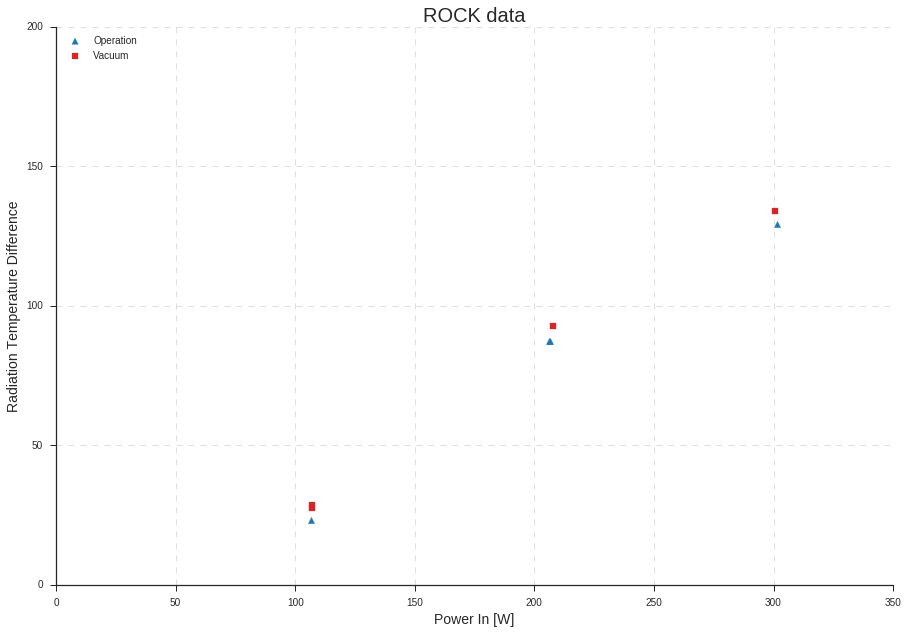

In [32]:
sns.set_style("white")
sns.set_style("ticks")
fig, ax = plt.subplots(figsize=(15, 10))

#50kg DATA
ax.scatter(pIn50[0:5], Radi[0:5], color =tableau20[0], s=40, marker="^", label="Operation")
ax.scatter(pIn50[5:9], Radi[5:9], color =tableau20[6], s=40, marker="s", label="Vacuum")

#graph options
plt.legend(loc='upper left')
plt.title('ROCK data', fontsize = 20)
plt.xlabel('Power In [W]', fontsize = 14)
plt.ylabel('Radiation Temperature Difference', fontsize = 14)

ax.set_ylim(ymin=0)
ax.set_xlim(xmin=0)

plt.grid(axis='y',color='grey', linestyle='--', lw=0.5, alpha=0.5)
plt.grid(axis='x',color='grey', linestyle='--', lw=0.5, alpha=0.5)
sns.despine()

# RCT008

In [4]:
dataBase = 'rct008'
eventsDf = getEvents(dataBase, path='/home/ihs3/Documents/Notebooks/Data/')
eventsDf

/home/ihs3/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:81: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
/home/ihs3/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:83: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
/home/ihs3/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:85: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)


,,,Start_Time,Stop_Time,Power,Gas,Pressure
eventId,dataBase,run,,,,,
0,rct008,002,2016-09-02 20:53:22.656483,2016-09-02 21:23:25.001846,0W,Helium,1
1,rct008,002,2016-09-02 23:23:34.822606,2016-09-02 23:53:37.056826,50W,Helium,1
2,rct008,002,2016-09-03 01:23:44.482824,2016-09-03 01:53:46.589858,100W,Helium,1
3,rct008,002,2016-09-03 03:23:53.809033,2016-09-03 03:53:56.234947,150W,Helium,1
4,rct008,002,2016-09-03 05:14:03.260932,2016-09-03 05:44:05.493683,200W,Helium,1
5,rct008,002,2016-09-03 07:04:12.197388,2016-09-03 07:34:14.433757,250W,Helium,1
6,rct008,002,2016-09-03 10:54:30.246108,2016-09-03 11:24:32.501776,0W,Helium,1
7,rct008,002,2016-09-03 14:55:24.894030,2016-09-03 15:25:27.313742,0W,Helium,10
8,rct008,002,2016-09-03 17:25:37.353149,2016-09-03 17:55:39.565753,50W,Helium,10


In [34]:
def findInputPower(eventTuple):
    CurrentSensor = 'v1'
    lineVoltageSensor = 'v4'
    
    datetime, lineVoltage = getEngData(lineVoltageSensor, eventTuple)
    datetime, fanCurrent = getEngData(CurrentSensor, eventTuple)
    
    PowerIn = np.mean(lineVoltage*fanCurrent)
    
    return PowerIn

def Temperatures(eventTuple):
    AmbientRTDs = ['amb_rtd1','amb_rtd2']
    ColdRTDs = ['rct_rtd1','rct_rtd2','rct_rtd9','rct_rtd10']
    WarmRTDs = ['rct_rtd3','rct_rtd4','rct_rtd7','rct_rtd8']
    HotRTDs = ['rct_rtd5','rct_rtd6']
    
    [date, Amb1] = getEngData(AmbientRTDs[0],eventTuple)
    [date, Amb2] = getEngData(AmbientRTDs[1],eventTuple)
    
    [date, Cold1] = getEngData(ColdRTDs[0],eventTuple)
    [date, Cold2] = getEngData(ColdRTDs[1],eventTuple)
    [date, Cold3] = getEngData(ColdRTDs[2],eventTuple)
    [date, Cold4] = getEngData(ColdRTDs[3],eventTuple)
    
    [date, Warm1] = getEngData(WarmRTDs[0],eventTuple)
    [date, Warm2] = getEngData(WarmRTDs[1],eventTuple)
    [date, Warm3] = getEngData(WarmRTDs[2],eventTuple)
    [date, Warm4] = getEngData(WarmRTDs[3],eventTuple)
    
    [date, Hot1] = getEngData(HotRTDs[0],eventTuple)
    [date, Hot2] = getEngData(HotRTDs[1],eventTuple)
    
    Ambient = np.mean((Amb1+Amb2)*0.5)
    Cold = np.mean((Cold1+Cold2+Cold3+Cold4)*0.25 - Ambient)
    Warm = np.mean((Warm1+Warm2+Warm3+Warm4)*0.25 - Ambient)
    ColdWarm = np.mean((Cold1+Cold2+Cold3+Cold4+Warm1+Warm2+Warm3+Warm4)*0.125 - Ambient)
    Hot = np.mean((Hot1+Hot2)*0.5 - Ambient)
    
    return Ambient, Cold, Warm, ColdWarm, Hot

In [35]:
eventTuple = eventsDf.index
# Ambient is the average of the two ambient rtds
# Cold is the average of the four outter rtds minus Ambient, then the mean is taken
# Warm is the average of the four middle rtds minus Ambient, then the mean is taken
# ColdWarm is the average of the eight non-center rtds minus Ambient, then the mean is taken
# Hot is the average of the two center rtds minus Ambient, then the mean is taken
rct008powerIn = ([])
rct008Amb = ([])
rct008Cold = ([])
rct008Warm = ([])
rct008ColdWarm = ([])
rct008Hot = ([])

for eventTup in eventTuple:
    rct008powerIn.append(findInputPower(eventTup))
    rct008Amb.append(Temperatures(eventTup)[0])
    rct008Cold.append(Temperatures(eventTup)[1])
    rct008Warm.append(Temperatures(eventTup)[2])
    rct008ColdWarm.append(Temperatures(eventTup)[3])
    rct008Hot.append(Temperatures(eventTup)[4])

# ALL DATA

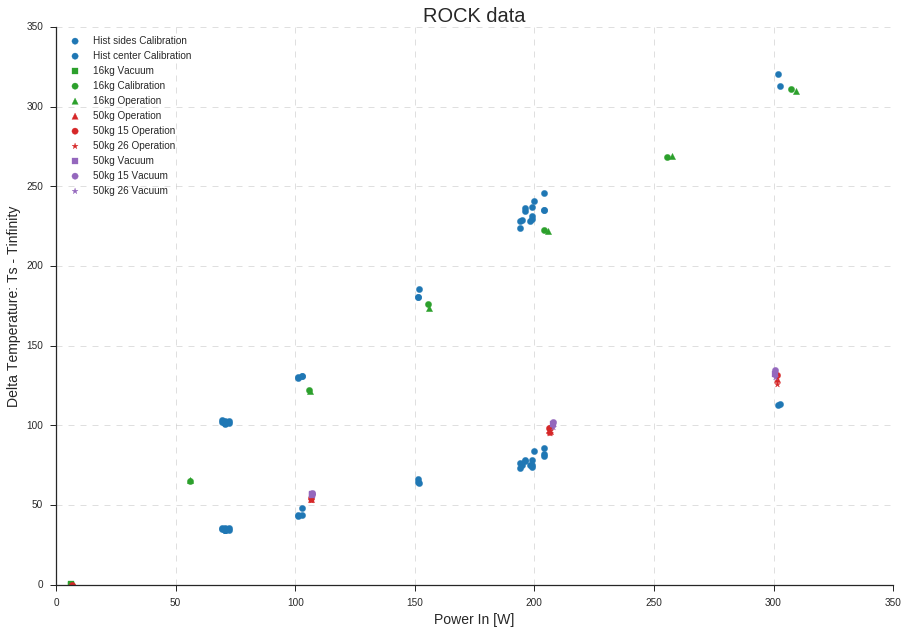

In [36]:
sns.set_style("white")
sns.set_style("ticks")
fig, ax = plt.subplots(figsize=(15, 10))

#HISTORICAL DATA
ax.scatter(calStatsDf['Power Mean'], (calStatsDf['Delta L']+calStatsDf['Delta R'])*0.5, color=tableau20[0], s=40, marker = 'o', label = 'Hist sides Calibration')
ax.scatter(calStatsDf['Power Mean'], calStatsDf['Delta C'], color=tableau20[0], s=40, marker = 'o', label = 'Hist center Calibration')
# ax.scatter( opStatsDf['Power Mean'], opStatsDf['Delta L']+opStatsDf['Delta R']*0.5, color=tableau20[6], s=40, marker = '^', label = 'Hist Operation')

#16kg DATA
ax.scatter(vacuumPowerInData, vacuumTemperatures, color = tableau20[4], s=40, marker="s", label="16kg Vacuum")
ax.scatter(calibrationPowerInData, calibrationTemperatures, color =tableau20[4], s=40, marker="o", label="16kg Calibration")
ax.scatter(operationPowerInData, operationTemperatures, color = tableau20[4], s=40, marker="^", label="16kg Operation")

#50kg DATA
ax.scatter(pIn50[0:5], Temp50[0:5], color =tableau20[6], s=40, marker="^", label="50kg Operation")
ax.scatter(pIn50[0:5], Temp15[0:5], color =tableau20[6], s=40, marker="o", label="50kg 15 Operation")
ax.scatter(pIn50[0:5], Temp26[0:5], color =tableau20[6], s=40, marker="*", label="50kg 26 Operation")
ax.scatter(pIn50[5:9], Temp50[5:9], color = tableau20[8], s=40, marker="s", label="50kg Vacuum")
ax.scatter(pIn50[5:9], Temp15[5:9], color = tableau20[8], s=40, marker="o", label="50kg 15 Vacuum")
ax.scatter(pIn50[5:9], Temp26[5:9], color = tableau20[8], s=40, marker="*", label="50kg 26 Vacuum")
# ax.scatter(pIn50[9], Temp50[9], color = tableau20[0], s=40, marker="o", label="50kg Heater Calibration")

#graph options
plt.legend(loc='upper left')
plt.title('ROCK data', fontsize = 20)
plt.xlabel('Power In [W]', fontsize = 14)
plt.ylabel('Delta Temperature: Ts - Tinfinity', fontsize = 14)

ax.set_ylim(ymin=0)
ax.set_xlim(xmin=0)

plt.grid(axis='y',color='grey', linestyle='--', lw=0.5, alpha=0.5)
plt.grid(axis='x',color='grey', linestyle='--', lw=0.5, alpha=0.5)
sns.despine()


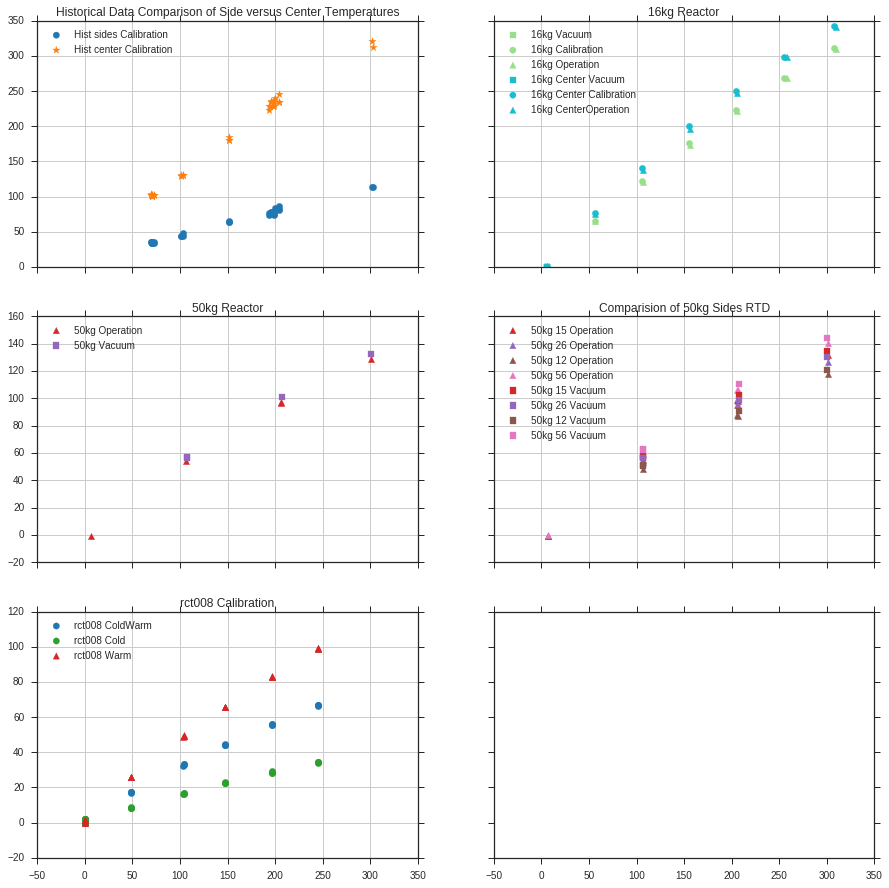

In [37]:
# sns.set_style("white")
# sns.set_style("ticks")
# fig, ax = plt.subplots(figsize=(15, 10))

# row and column sharing
f, ((ax1, ax2), (ax3, ax4),(ax5,ax6)) = plt.subplots(3, 2, sharex='col', sharey='row', figsize = (15,15))
ax1.scatter(calStatsDf['Power Mean'], (calStatsDf['Delta L']+calStatsDf['Delta R'])*0.5, color=tableau20[0], s=40, marker = 'o', label = 'Hist sides Calibration')
ax1.scatter(calStatsDf['Power Mean'], calStatsDf['Delta C'], color=tableau20[2], s=60, marker = '*', label = 'Hist center Calibration')
ax1.set_title('Historical Data Comparison of Side versus Center Temperatures')
ax1.set_ylim(0, 350)
ax1.legend(loc='upper left')
ax1.grid()

ax2.scatter(vacuumPowerInData, vacuumTemperatures, color = tableau20[5], s=40, marker="s", label="16kg Vacuum")
ax2.scatter(calibrationPowerInData, calibrationTemperatures, color =tableau20[5], s=40, marker="o", label="16kg Calibration")
ax2.scatter(operationPowerInData, operationTemperatures, color = tableau20[5], s=40, marker="^", label="16kg Operation")
ax2.scatter(vacuumPowerInData, vacuumCenterTemps, color = tableau20[18], s=40, marker="s", label="16kg Center Vacuum")
ax2.scatter(calibrationPowerInData, calibrationCenterTemps, color = tableau20[18], s=40, marker="o", label="16kg Center Calibration")
ax2.scatter(operationPowerInData, operationCenterTemps, color = tableau20[18], s=40, marker="^", label="16kg CenterOperation")
# ax2 = sns.regplot(x = np.array(calibrationPowerInData), y = np.array(calibrationTemperatures), ci = 99, line_kws={'lw': 2}, color = tableau20[4], scatter=False)
ax2.set_title('16kg Reactor')
ax2.set_ylim(0, 350)
ax2.legend(loc='upper left')
ax2.grid()

ax3.scatter(pIn50[0:5], Temp50[0:5], color =tableau20[6], s=40, marker="^", label="50kg Operation")
ax3.scatter(pIn50[5:9], Temp50[5:9], color = tableau20[8], s=40, marker="s", label="50kg Vacuum")
ax3.set_title('50kg Reactor')
# ax3.set_ylim(0, 350)
ax3.legend(loc='upper left')
ax3.grid()

ax4.scatter(pIn50[0:5], Temp15[0:5], color =tableau20[6], s=40, marker="^", label="50kg 15 Operation")
ax4.scatter(pIn50[0:5], Temp26[0:5], color =tableau20[8], s=40, marker="^", label="50kg 26 Operation")
ax4.scatter(pIn50[0:5], Temp12[0:5], color =tableau20[10], s=40, marker="^", label="50kg 12 Operation")
ax4.scatter(pIn50[0:5], Temp56[0:5], color =tableau20[12], s=40, marker="^", label="50kg 56 Operation")
ax4.scatter(pIn50[5:9], Temp15[5:9], color = tableau20[6], s=40, marker="s", label="50kg 15 Vacuum")
ax4.scatter(pIn50[5:9], Temp26[5:9], color = tableau20[8], s=40, marker="s", label="50kg 26 Vacuum")
ax4.scatter(pIn50[5:9], Temp12[5:9], color = tableau20[10], s=40, marker="s", label="50kg 12 Vacuum")
ax4.scatter(pIn50[5:9], Temp56[5:9], color = tableau20[12], s=40, marker="s", label="50kg 56 Vacuum")
ax4.set_title('Comparision of 50kg Sides RTD')
ax4.legend(loc='upper left')
ax4.grid()

ax5.scatter(rct008powerIn, rct008ColdWarm, color=tableau20[0], s=40, marker = 'o', label = 'rct008 ColdWarm')
ax5.scatter(rct008powerIn, rct008Cold, color=tableau20[4], s=40, marker = 'o', label = 'rct008 Cold')
ax5.scatter(rct008powerIn, rct008Warm, color=tableau20[6], s=40, marker = '^', label = 'rct008 Warm')
ax5.set_title('rct008 Calibration')
ax5.legend(loc='upper left')
ax5.grid()
# ax4 = sns.regplot(x = np.array(pIn50[5:9]), y = np.array(Temp15[5:9]), ci = 99, line_kws={'lw': 2}, color = tableau20[4], scatter=False)
# ax4.set_ylim(0, 350)

# ax4 = sns.regplot(x = pIn50[5:9], y = Temp15[5:9], ci=95)